# Manufacturing
## Time to Failure Since Repair

In manufacturing machine failure means less production, potentially unforeseen expenses, and consequently less revenue. Hence as a manufacturer we want to find ways to predict and reduce machine failure. This can be achieved by estimating *time to failure since repair*. 

Imagine a car. Throughout its lifetime it undergoes a series of repairs. Each time it undergoes a repair it becomes censored, and we restart the clock. At some point in this cycle the car may finally break (face the event). 

TIME = 0 ###### TIME = 75 CLUTCH CHANGE (BECOMES CENSORED)\
TIME = 0 ############ TIME = 150 TRANSMISSION CHANGE (BECOMES CENSORED)\
TIME = 0 #################### TIME = 200 MOTOR CHANGE (BECOMES CENSORED)\
TIME = 0 ########## TIME = 100 BEYOND REPAIR (EVENT REACHED)

Some cars remain in driving condition for many years, and can for short term purposes be considered "cured". 

We can estimate time to failure since repair using apd-crs, incorporating the idea that some machines are resilient and don’t fail before they’re replaced.

This scenario can be modeled as a cure rate survival (crs) analysis problem with the following characteristics:

 - <b>Event of interest</b>: The machine is beyond repair (machine failure)
 
 - <b>Time-to-event</b>: The time difference between the acquisition/repair of a machine and the machine failure
 
 - <b>Cured population</b>: Machines which never fail
 


In [1]:
import warnings
warnings.filterwarnings("ignore")

## Imports 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sksurv.preprocessing import OneHotEncoder
from apd_crs.survival_analysis import SurvivalAnalysis
from apd_crs.datasets import load_manufacturing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## The Manufacturing Dataset

For illustration we use the following [data set](https://square.github.io/pysurvival/tutorials/maintenance.html) from the PySurvival library . The data has the following characteristics: 

- A manufacturing plant may have several machines of a certain type. 
- Each machine instance can undergo many repairs over the course of its tenure. 
- This would lead to a multitude of censored observations for time since repair, with each specific machine likely contributing to several observations, since it may be repaired more than once during its tenure.
- Each machine has associated covariates like pressure index, moisture index, the team working with it, etc.
- After preprocessing the data, we would obtain a table like the one below.

In [4]:
# loading the data
dataset = load_manufacturing()
data, labels, times = dataset.data, dataset.target, dataset.target_times
dataset["data"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pressureInd     1000 non-null   float64
 1   moistureInd     1000 non-null   float64
 2   temperatureInd  1000 non-null   float64
 3   team            1000 non-null   object 
 4   provider        1000 non-null   object 
dtypes: float64(3), object(2)
memory usage: 39.2+ KB


The dataset contains 5 columns and 1000 rows. Some of the columns include numerical data while others include string data. Lets view a few top rows of the data to see what it looks like

In [5]:
dataset["data"].head()

,pressureInd,moistureInd,temperatureInd,team,provider
0,92.178854,104.230204,96.517159,TeamA,Provider4
1,72.075938,103.065701,87.271062,TeamC,Provider4
2,96.272254,77.801376,112.196170,TeamA,Provider1
3,94.406461,108.493608,72.025374,TeamC,Provider2
4,97.752899,99.413492,103.756271,TeamB,Provider1


## Using the SurvivalAnalysis Class
The apd_crs module expects censored data to be marked using _censor_label_ and cured data to be marked using _cure_label_. These can be obtained with the get_censor_label and get_cure_label methods as follows

In [6]:
# Instantiate the SurvivalAnalysis class and get labels
model = SurvivalAnalysis()
non_cure_label = model.get_non_cure_label()
censor_label = model.get_censor_label()

The load_manufacturing() method returns a dataset where the labels have been suitably preprocessed already. However, make sure to suitably convert the labels when applying SurvivalAnalysis on your datasets!

In [7]:
# In the manufacturing dataset, label of 2 implies censored, and 1 implies non_cured
labels = labels.replace({2: censor_label, 1: non_cure_label})

## One-hot encoding

Our data includes columns such as "provider" which could take the value of one of four providers. We obviously need to convert categorical values into numerical values before we can use them for our model. This is achieved through one-hot encoding. 

In [8]:
categorical_columns = ["team", "provider"]

encoded_data = pd.get_dummies(data, columns=categorical_columns, 
                              prefix=categorical_columns)

## Train test split

We split the data into training and test sets. The model is fit on training data and evaluated on test data

In [9]:
# Test train split: To evaluate test performance we split the data into training and testing data;
# test_size is percentage going to test data
test_size = 0.33
(training_data, test_data, training_labels,
 test_labels, training_times, test_times) = train_test_split(encoded_data, 
                                                             labels, times, 
                                                             test_size=test_size)

## Scaling
To ensure that a certain feature does not dominate other features due to its numerical range, we scale all features so they lie within the same range

In [10]:
# Scale covariates:
scaler = StandardScaler()
scaled_training_data = scaler.fit_transform(training_data)

# Scale times:
scaled_training_times = training_times / training_times.max()

## Using the SurvivalAnalysis Class: Model Fitting

In [11]:
# surv_reg_term controls regularization for the fitting of lifetime parameters

model.survival_fit(scaled_training_data, training_labels, 
                   scaled_training_times, surv_reg_term=0.9, is_scar=True)

Before evaluating results, make sure to apply the same scaling that was applied to training data

In [12]:
scaled_test_data = scaler.transform(test_data)
scaled_test_times = test_times / training_times.max()

## Evaluating Model Performance

### Danger 
The Danger associated with an individual is a measure of the individual's risk of facing the event. It can take on any real number.

The higher the Danger, the higher the risk associated with an individual. E.g. an individual with Danger -1.2 is less at risk than one with Danger 1.0.

The danger can be calculated using the predict_danger method,





### Concordance Index (C-Index)

Two individuals are comparable if one experiences the event before the other. A pair of individuals is concordant if the one which "died" first has a higher danger. If our model is fit well, an individual for which we predict a higher danger is more likely to face the event of interest before another individual for which we predict a lower danger. This idea if formalized with the notion of c-index.

C-Index = ratio of concordant pairs to comparable pairs. 

Clearly C-index is in $[0,1]$ and the higher the better. 

Random guessing $\Rightarrow$ C-index = 0.5

### Danger Calculation

In [13]:
train_danger = model.predict_danger(scaled_training_data, training_labels)
test_danger = model.predict_danger(scaled_test_data, test_labels)

### C-Index Calculation

In [14]:
train_score = model.cindex(scaled_training_times, training_labels, train_danger)
test_score = model.cindex(scaled_test_times, test_labels, test_danger)
print(f"c-index score on train set is {train_score}")
print(f"c-index score on test set is {test_score}")

c-index score on train set is 0.7389845271031869
c-index score on test set is 0.7754171416727123


## Overall Risk Factors
The relative risk factors associated with every covariate in the dataset can be obtained using the get_risk_factors methood. Let us retrieve the top 10 factors in absolute value to get an idea of what they are

<AxesSubplot:>

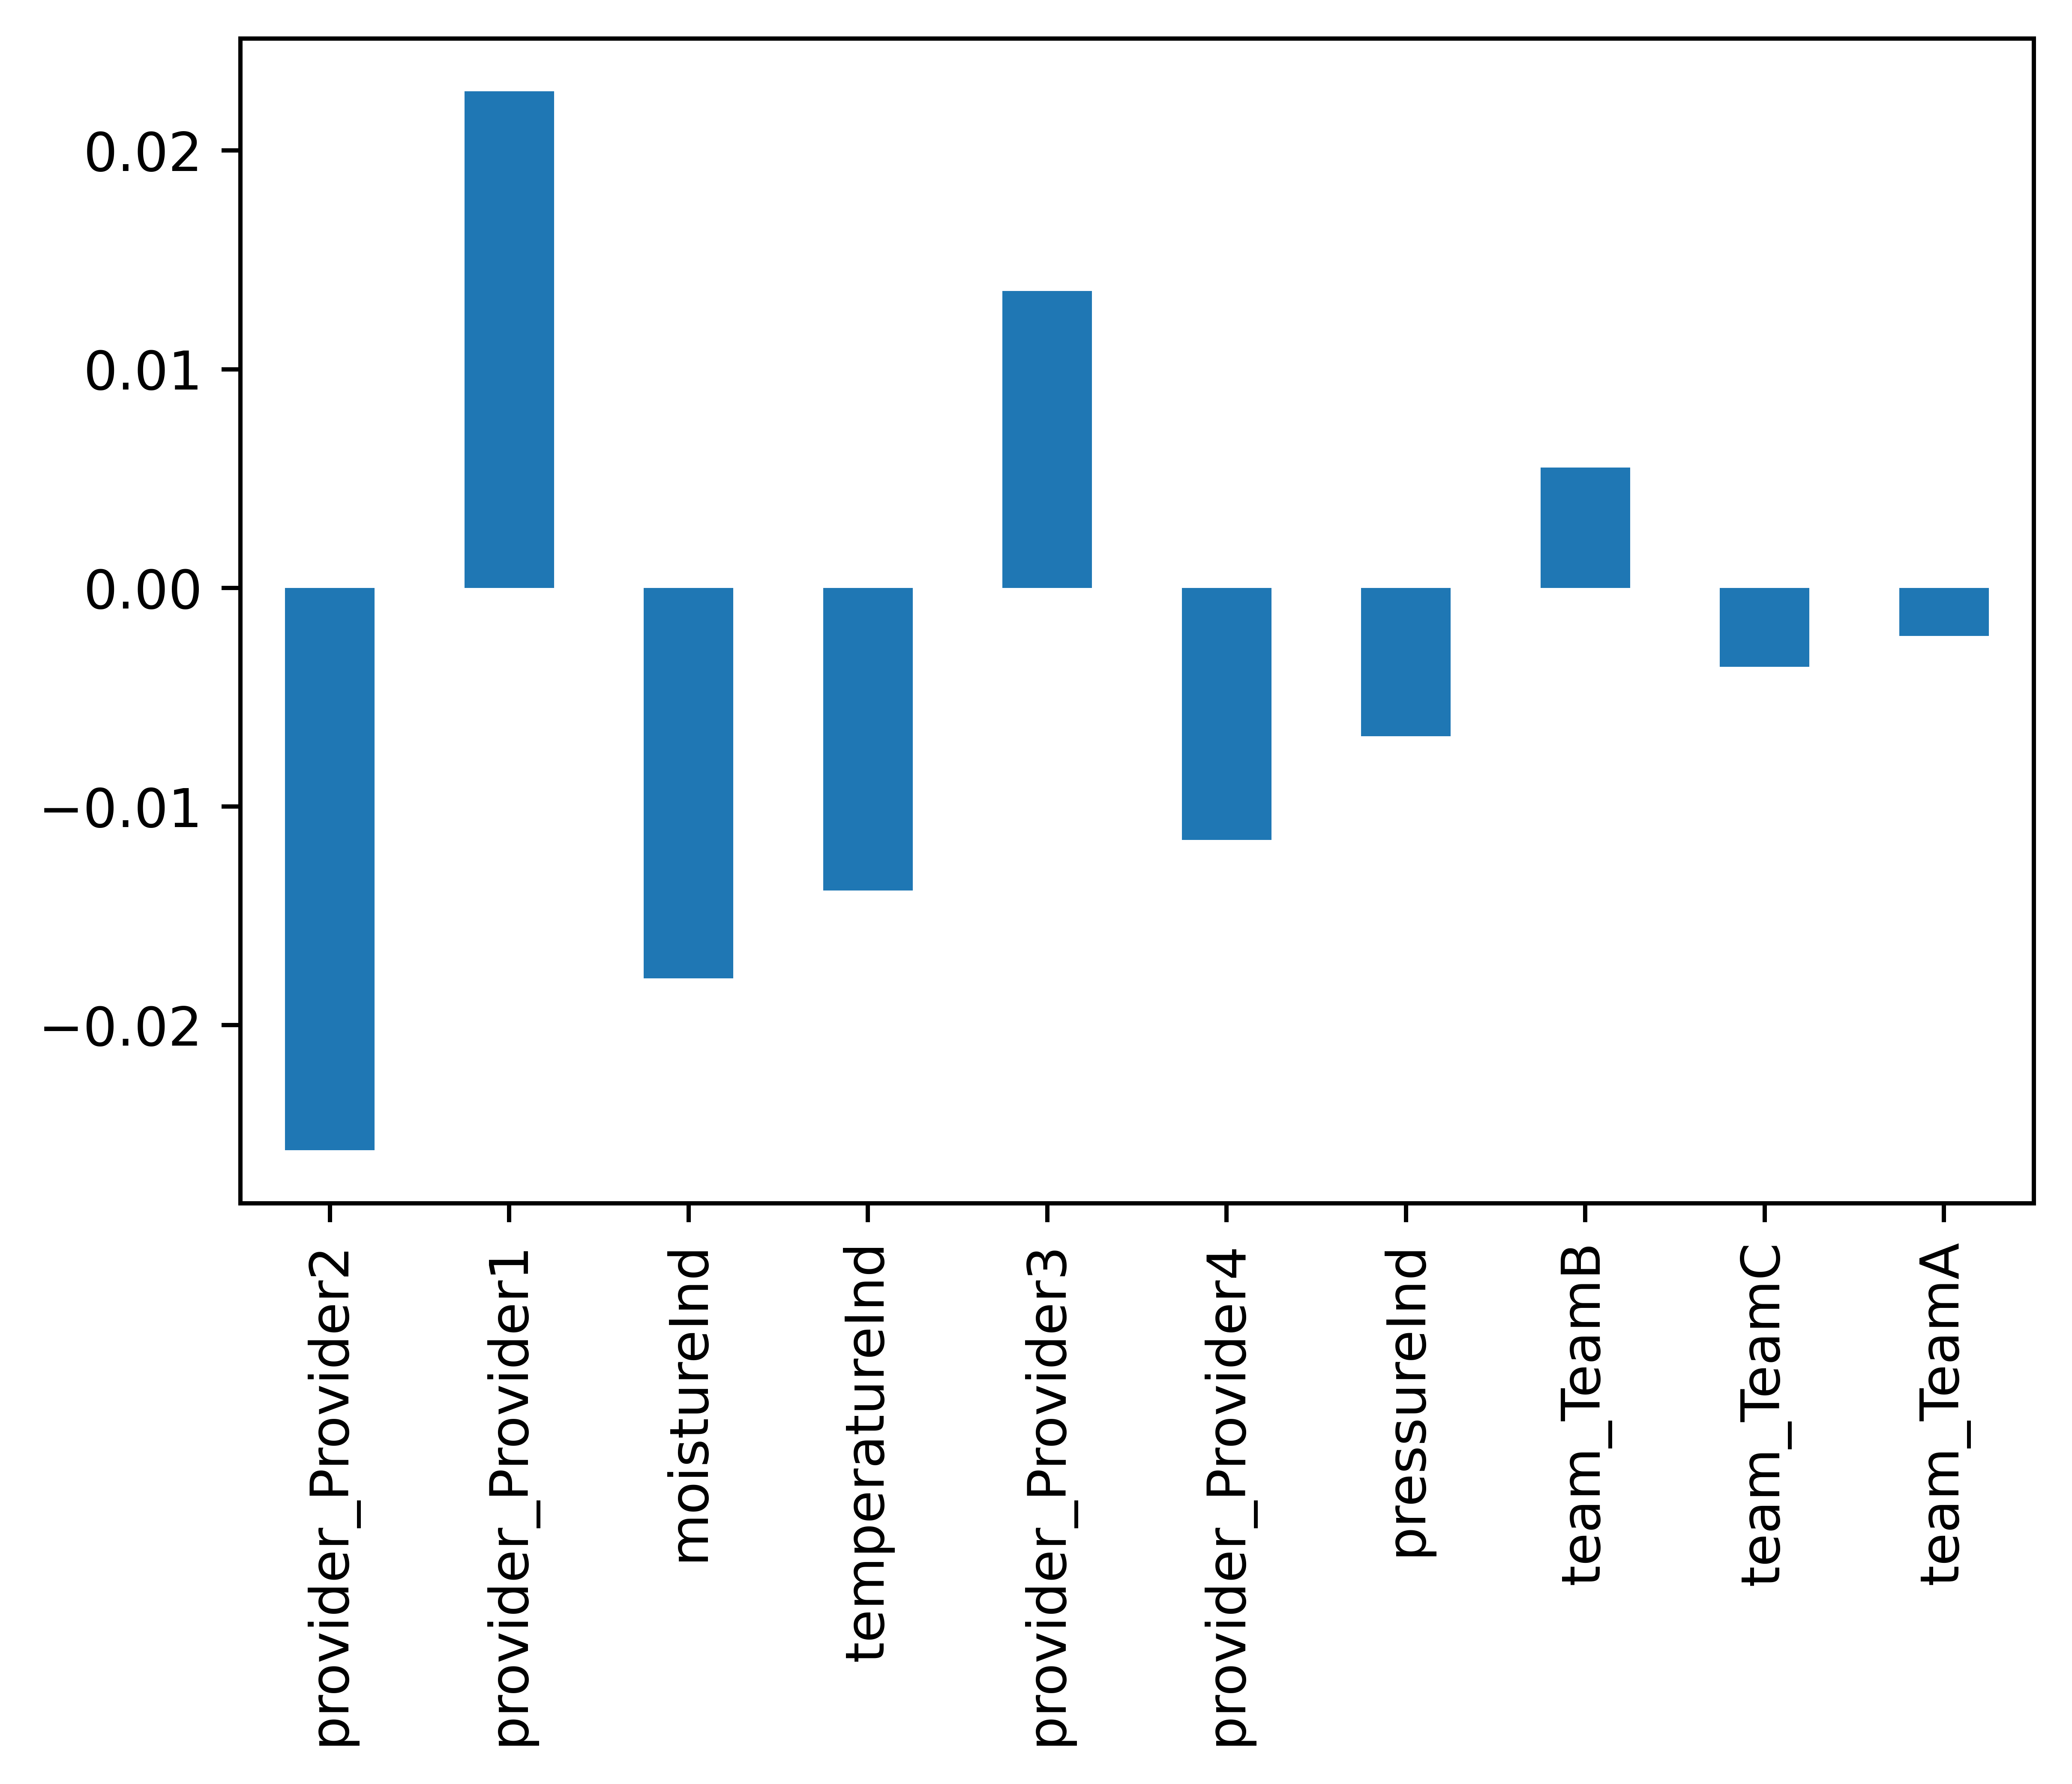

In [15]:
factors = model.get_risk_factors()
n_factors = len(factors)
risk_factors = pd.Series(
    {encoded_data.columns[i]: factors[i] for i in range(n_factors)}
)
top_ten_factors_in_absvalue = risk_factors.abs().sort_values(ascending=False)[0:10]
risk_factors.filter(top_ten_factors_in_absvalue.index).plot.bar()

## Individual Predictions
The probability of survival of any individual decreases with time. Let us plot the overall survival function for the first five individuals in the test set. Note that the times have been normalized to lie between 0 and 1. 

In [16]:
time_lower_bnd = 0.003
time_upper_bnd = 1.
times = np.arange(time_lower_bnd, time_upper_bnd, 0.01)
repeats_array = np.tile(times, (len(test_data), 1))
ovpr = model.predict_overall_survival(scaled_test_data, repeats_array, test_labels)
# We can include the corresponding probabilities of cure in a legend
cure_probs = [np.around((model.predict_cure_proba(scaled_test_data, test_labels)[0:5, 0])[i], 
                        decimals=2) for i in range(5)]

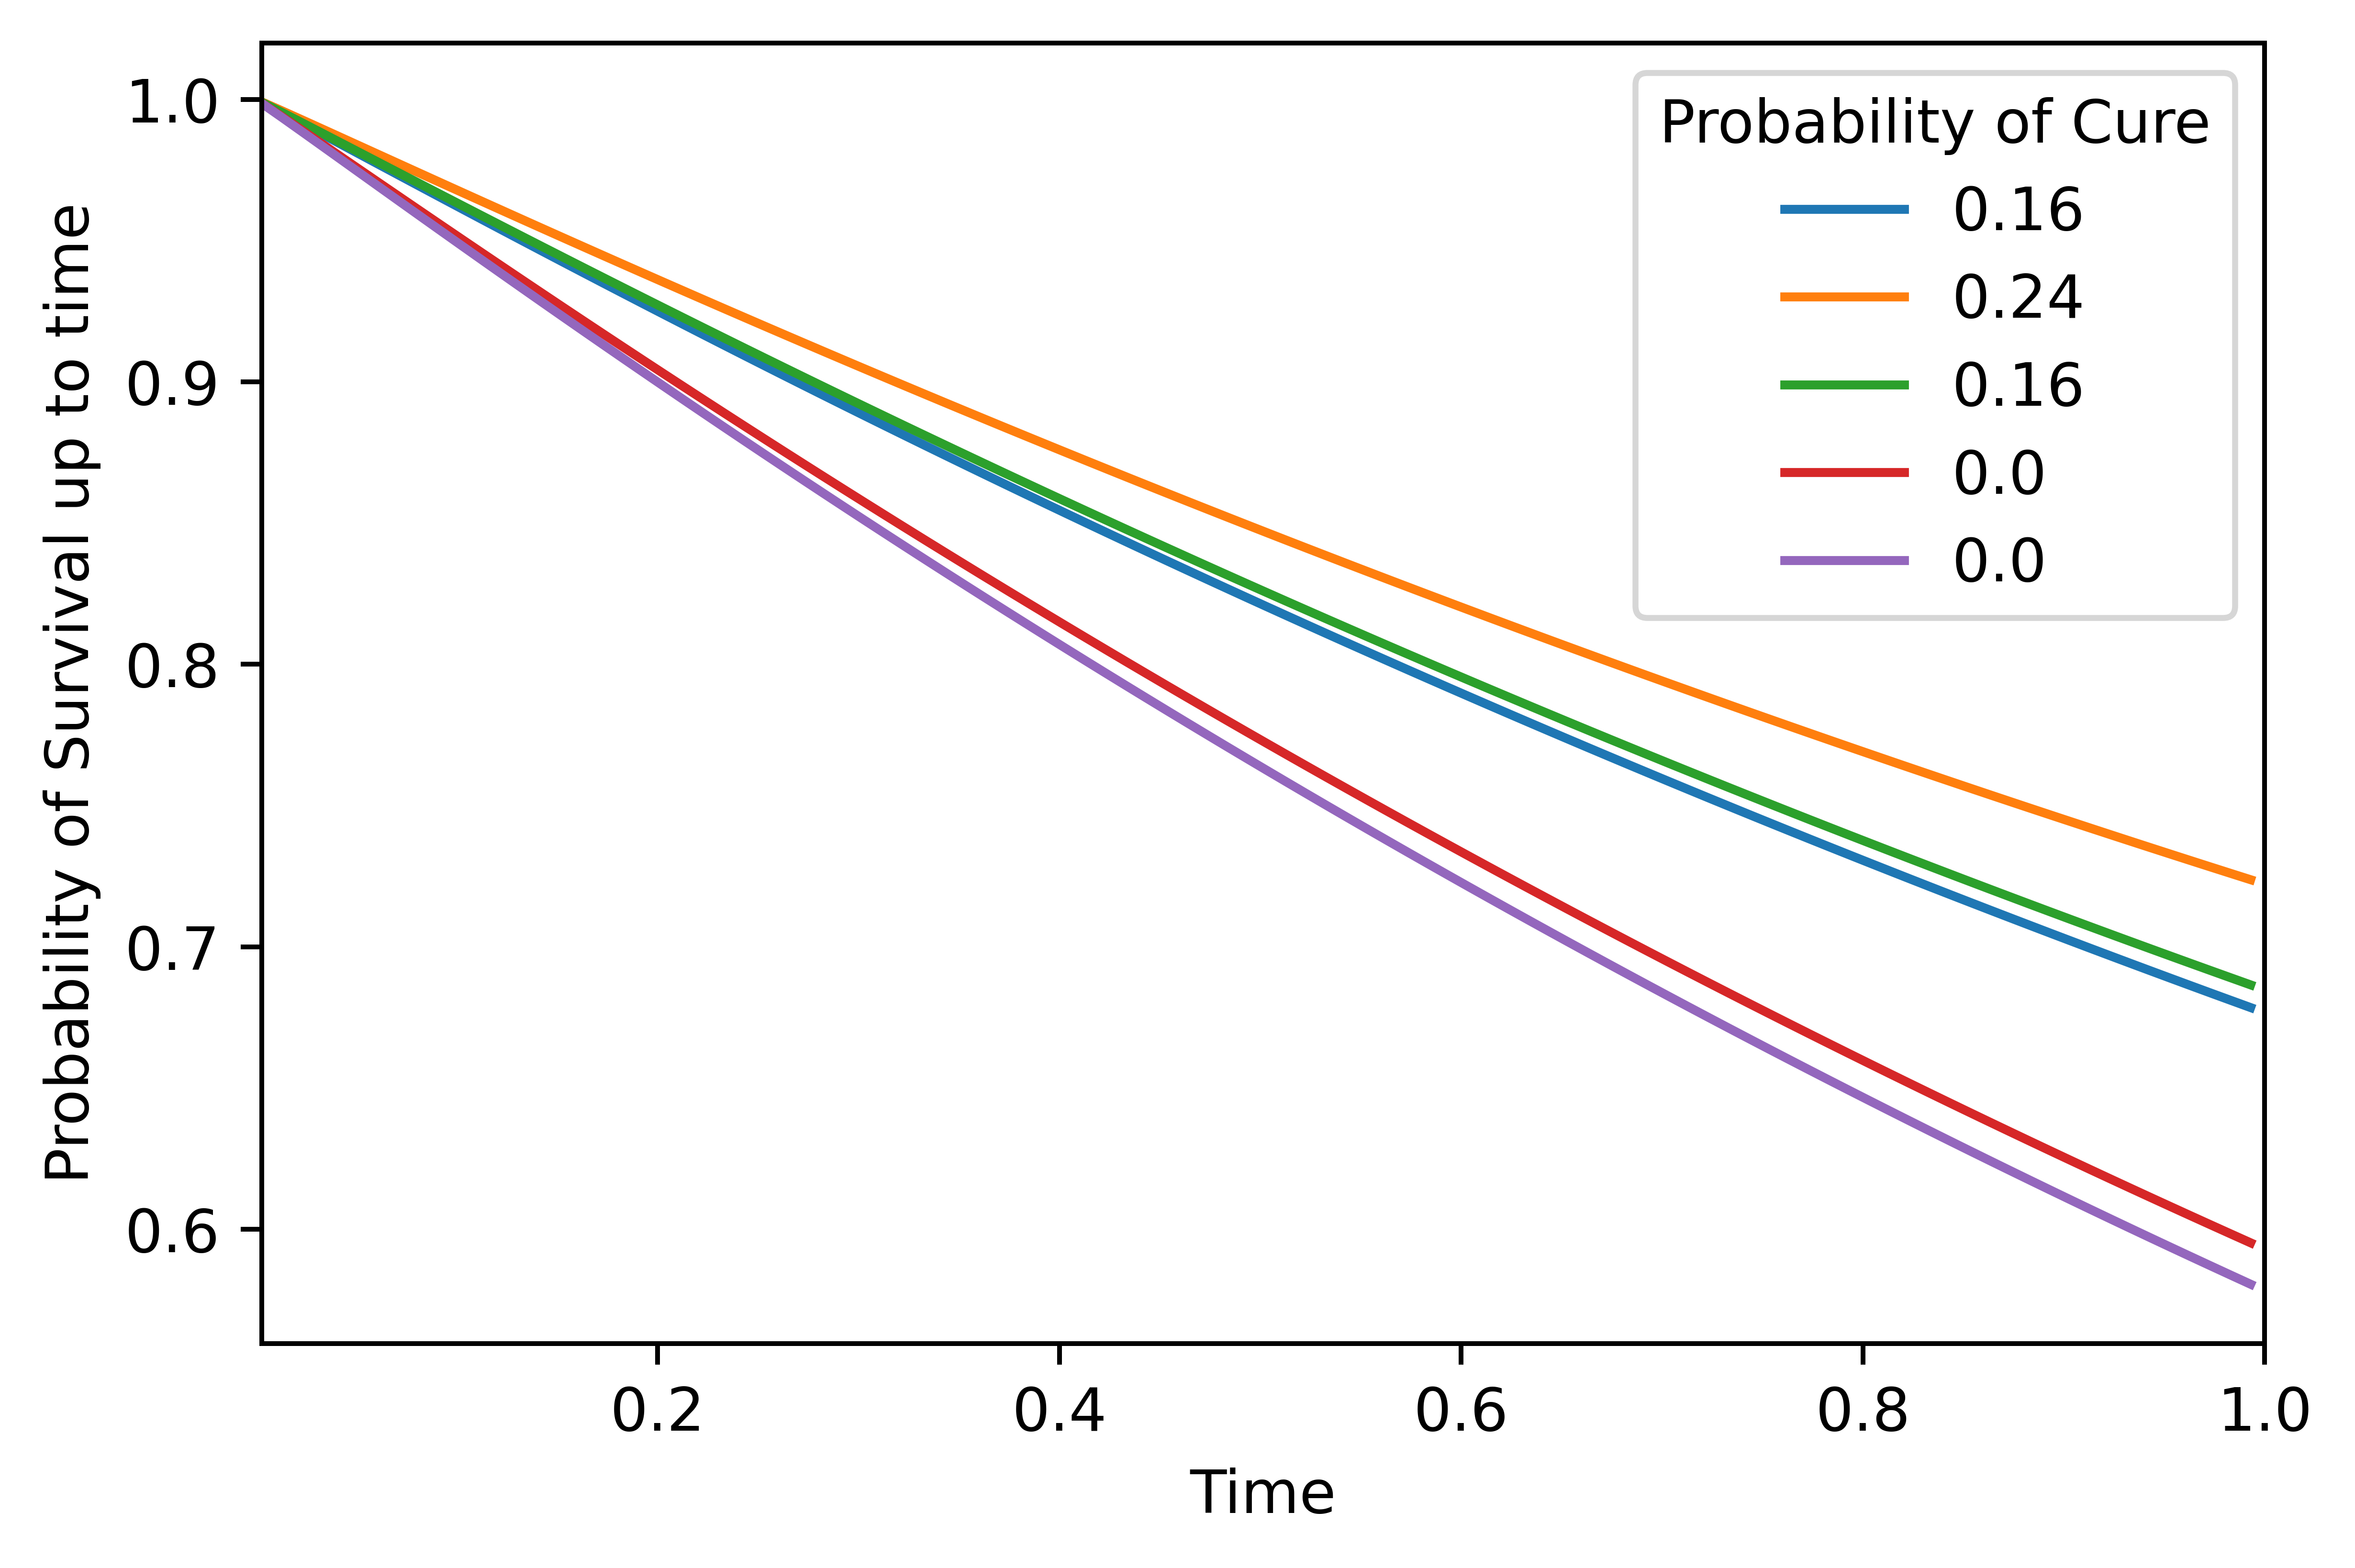

In [17]:
# We are viewing the overall survival function of the first five records in the test data, labelled with cure probability
no_records = 5
y = ovpr[0:no_records, :]
x = times
plt.plot(x, y.T)
plt.xlim([time_lower_bnd, time_upper_bnd])
plt.xlabel("Time")
plt.ylabel("Probability of Survival up to time")
plt.legend(labels=cure_probs, loc="upper right", title="Probability of Cure")
plt.show()